In [6]:
import os
import simulation
import pynbody
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import ipywidgets
import tqdm
import pickle
from data_pd.dump_features import dump_features, make_df
from simulation.sfh_in_box import plot_binned_sfh
from astropy.table import Table
import astropy.units as u

In [2]:
SIM_NUM = '71002'
TRAJ = 'p50_a800_r600'
SIM = 'mb.{}'.format(SIM_NUM)
MORIA_CACHE = 'moria{}.fits'.format(SIM_NUM)

In [3]:
SIMPATH = '/home/michele/sim/MySimulations/ng'
sim_path = os.path.join(SIMPATH, "{}_{}".format(SIM, TRAJ), "out")
sim = simulation.Simulation(sim_path, snap_indexes=slice(None, None, 1))

loading simulation: /home/michele/sim/MySimulations/ng/mb.71002_p300_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Taking 563 snapshots (slice(None, None, 1))
Loading cosmological parameters
Found trace file


In [4]:
from simulation.units import gadget_time_units, gadget_dens_units
conv_fac = gadget_time_units.in_units('Gyr')
conv_fac

0.9778139512067809

In [5]:
# dump_features(sim, 'data_pd/{}_{}_s5.pickle'.format(SIM,TRAJ))

In [8]:
load_cache = True
if load_cache:
    filename = 'data_pd/{}_{}_s5.fits'.format(SIM,TRAJ)
    tbl = Table.read(filename)
    df = tbl.to_pandas()
#     times, mass, sigma_star, sigma_gas, r_eff, sfr = pickle.load(open(filename, 'rb'))
# data = pickle.load(open(filename, 'rb'))
# data[-1] = sfr
# pickle.dump(data, open(filename, 'wb'))

In [ ]:
moria_s = simulation.MoriaSim(SIM_NUM)[-1]

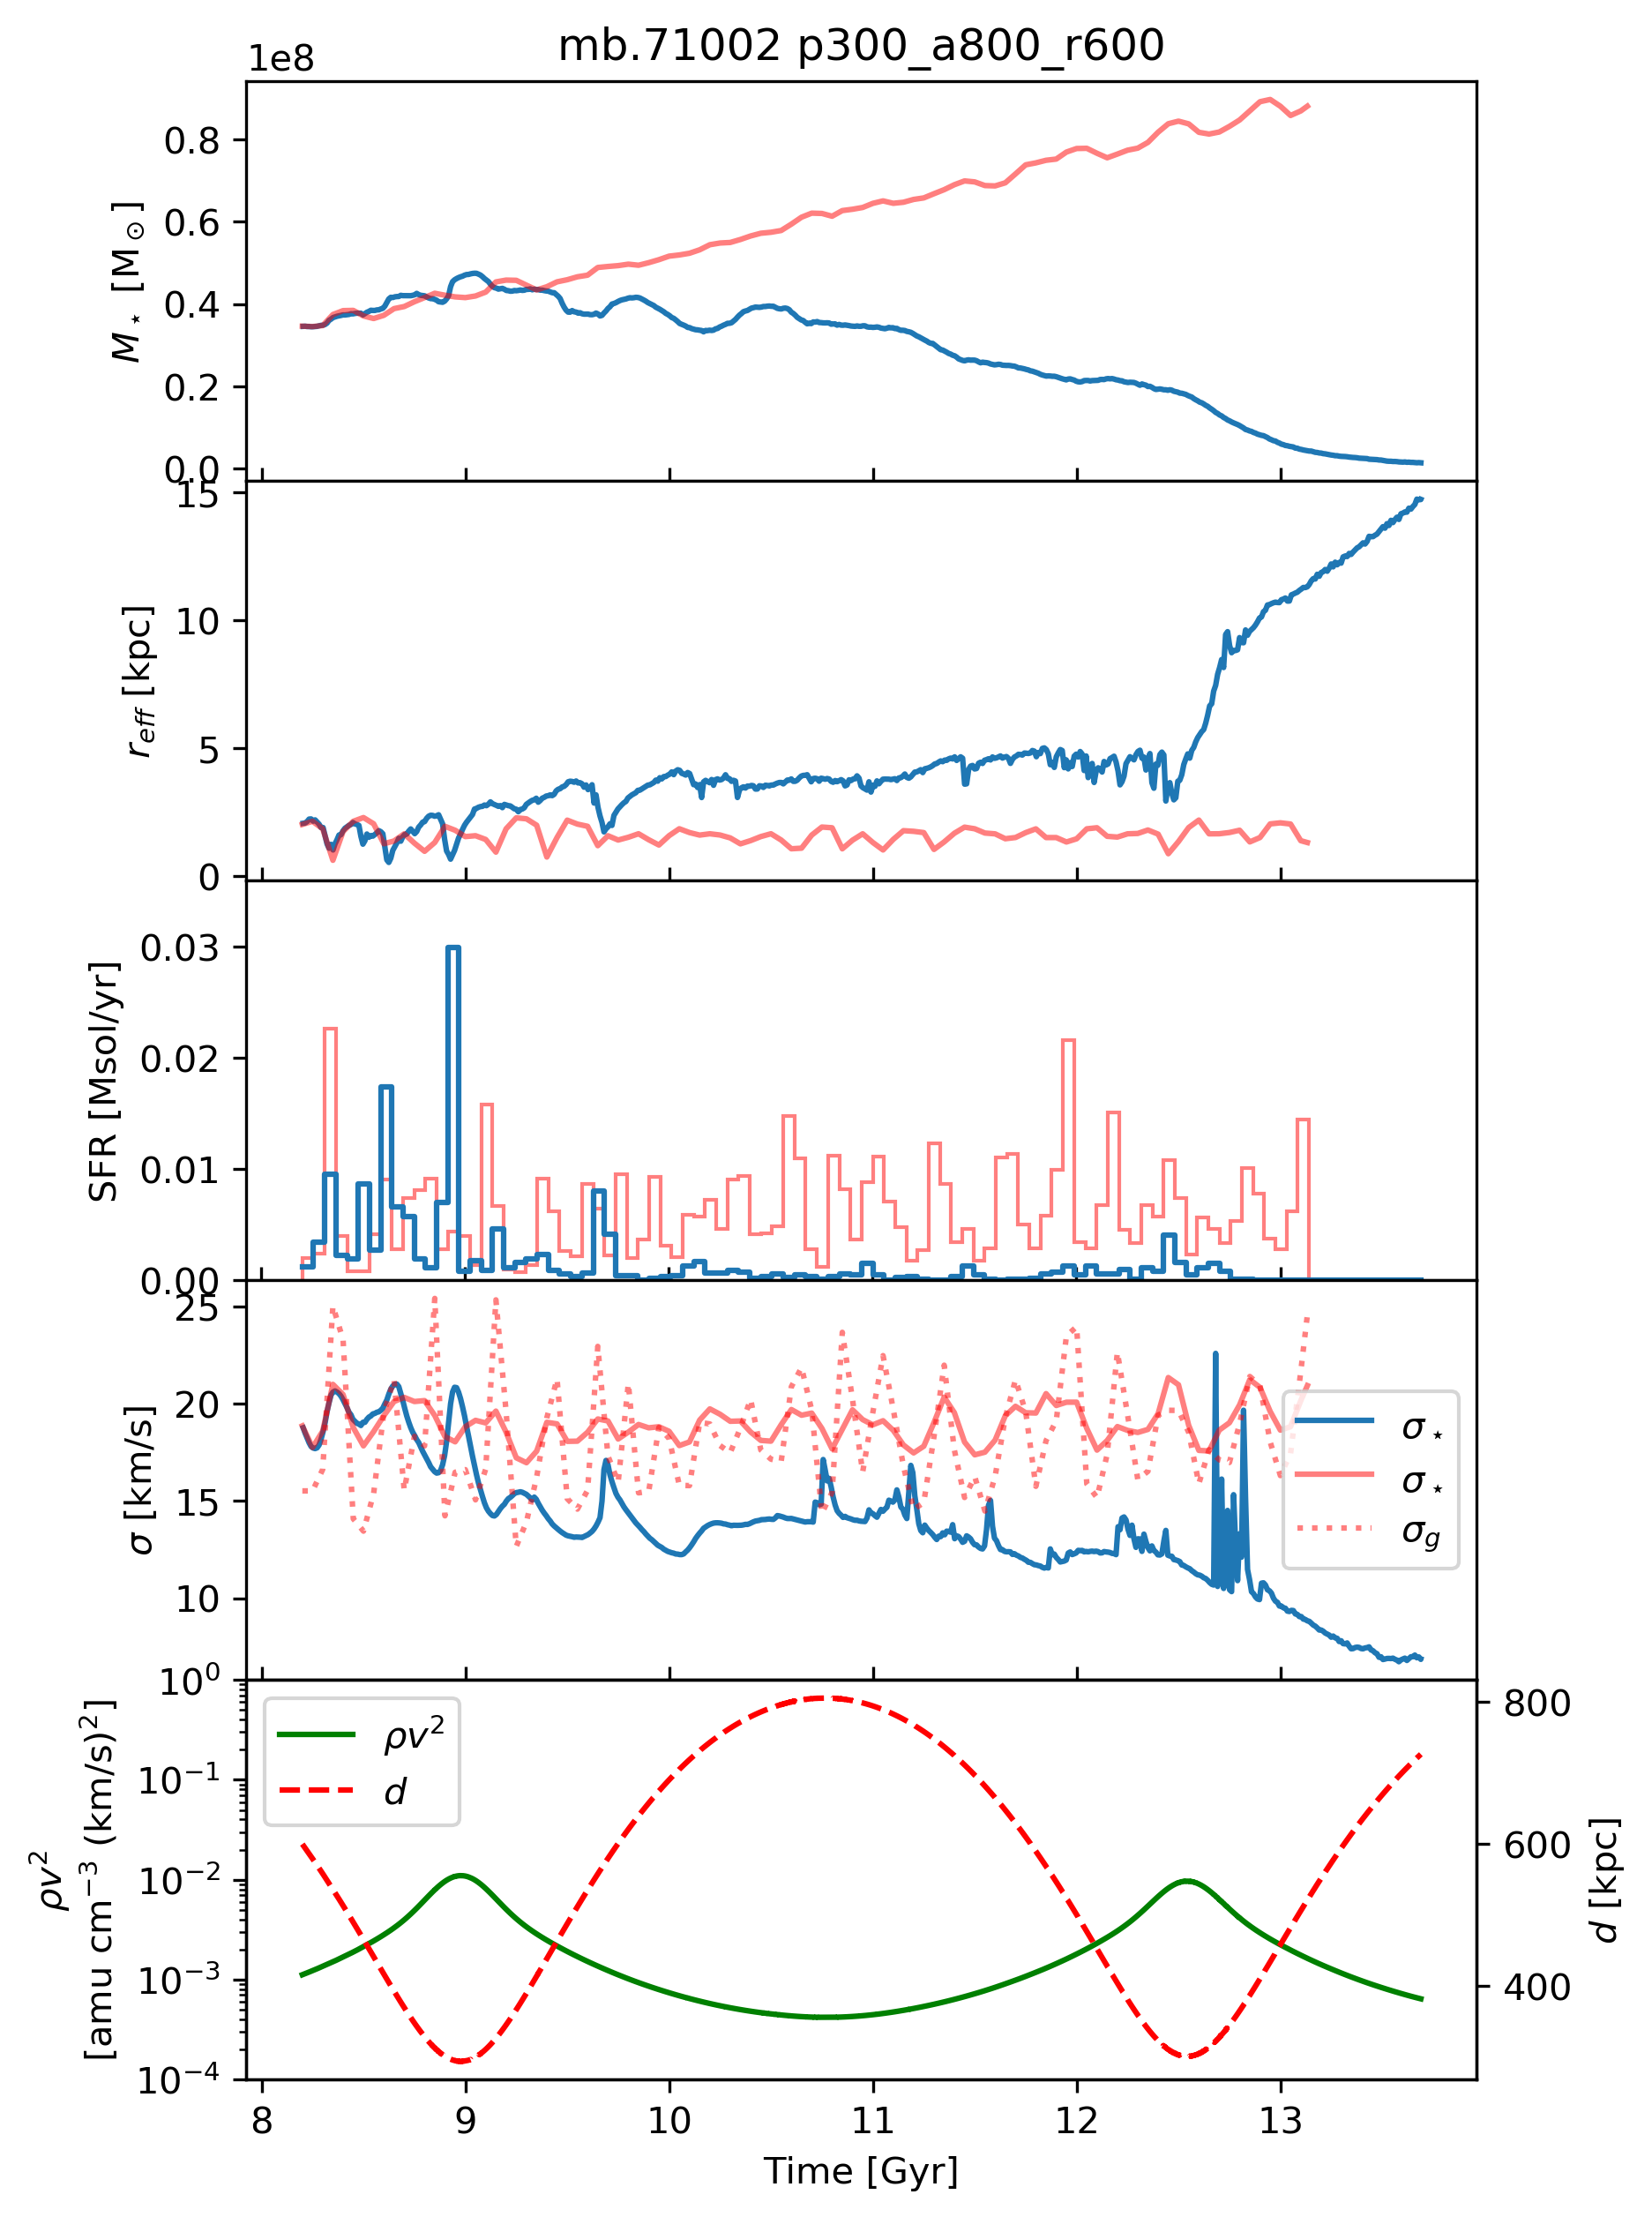

In [14]:
fig, (ax_m_star, ax_r_eff, ax_sfh, ax_sigma, ax_ram) = plt.subplots(5, figsize=(8,10), dpi=300)
ax_m_star.plot(df.t, df.mass_star)
# ax_m_star.set_xlabel("Time [Gyr]")
ax_m_star.set_ylabel("$M_\star$ [M$_\odot]$");
ax_m_star.ticklabel_format(style='sci', scilimits=(0,0))
ax_m_star.set_title('{} {}'.format(SIM, TRAJ));

ax_r_eff.plot(df.t, df.r_eff)
# ax_r_eff.set_xlabel("Time [Gyr]")
ax_r_eff.set_ylabel("$r_{eff}$ [kpc]");
ax_r_eff.set_ylim(0, 24)

bins_sfh = 100
hist, binedges = plot_binned_sfh(sim, bins=bins_sfh, ax=ax_sfh)
max_sfr = np.max(hist)

ax_ram.set_xlabel("Time [Gyr]")
ax_ram.set_ylabel(r"""$\rho v^2$
[amu cm$^{-3}$ (km/s)$^2$]""");
# ax_ram.set_ylabel(r"""$\rho v^2$
# [10$^{10}$ M$_\odot$ kpc$^-3$ (km/s)$^2$]""");

ax_sigma.plot(df.t, df.sigma_star, label='$\sigma_\star$')
# ax_sigma.plot(df.t, df.sigma_gas, 'C0:', label='$\sigma_g$')
# ax_sigma.set_xlabel("Time [Gyr]")
ax_sigma.set_ylabel("$\sigma$ [km/s]");
# [a.semilogy() for a in fig.axes]

ram_pressure = pynbody.array.SimArray(sim.dens_trace.rho.values, gadget_dens_units).in_units('amu cm^-3')*sim.dens_trace.vel
ax_ram.plot(sim.dens_trace.t*conv_fac, ram_pressure, color='g', label=r'$\rho v^2$')
ax_ram.set_yscale('log')
ax_ram.set_ylim(1e-4, 1)

ax_d = ax_ram.twinx()
ax_d.plot(sim.dens_trace.t*conv_fac, sim.dens_trace.r, 'r--', label='$d$')
ax_d.set_ylabel("$d$ [kpc]")
# Manage the labels of ram pressure and distance
lines2, labels2 = ax_d.get_legend_handles_labels()
lines, labels = ax_ram.get_legend_handles_labels()
ax_d.legend(lines + lines2, labels + labels2, loc=0)

## Plot the Moria values
# data = [times, mass, sigma_star, sigma_gas, r_eff]
tbl_m = Table.read(MORIA_CACHE)
alpha = 0.5
# pynbody.analysis.halo.center(snap.s)
ax_m_star.plot(tbl_m['t'][65:], tbl_m['mass_star'][65:], 'r', alpha=alpha);
ax_r_eff.plot(tbl_m['t'][65:], tbl_m['r_eff'][65:], 'r', alpha=alpha);
ax_sigma.plot(tbl_m['t'][65:], tbl_m['sigma_star'][65:], 'r', alpha=alpha, label='$\sigma_\star$')
ax_sigma.plot(tbl_m['t'][65:], tbl_m['sigma_gas'][65:], 'r:', alpha=alpha, label='$\sigma_g$');
ax_sigma.legend();

sfhist, thebins = pynbody.plot.sfh(moria_s, range=(df.t[0], df.t.iloc[-1]), subplot=ax_sfh, bins=bins_sfh, alpha=alpha, color='r')
if ax_sfh.get_ylim()[1] < 1.2 * max_sfr:
    ax_sfh.set_ylim(0.0, 1.2 * max_sfr)

# ax_m_star.set_ylim(bottom=0, top=3e8)
# ax_r_eff.set_ylim(bottom=0, top=4.5)
# ax_sigma.set_ylim(bottom=0, top=39)
# if TRAJ[1:].startswith() == '100':
#     ax_ram.set_ylim(bottom=0, top=2)
# elif TRAJ[1] == '3':
#     ax_ram.set_ylim(bottom=0, top=1.69)


fig.subplots_adjust(hspace=0)

for i, ax in enumerate(fig.axes):
    ax.tick_params(axis='y', direction="out")
#     print(i, ax.get_ylabel())

for ax in fig.axes[:-3]:
    ax.tick_params(axis='x', direction="in")
    plt.setp(ax.get_xticklabels(), visible=False)

# remove z label
plt.setp(fig.axes[-1], visible=False);


In [8]:
fig.savefig('{} {}.png'.format(SIM, TRAJ))